<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Depp Learning - Dr. Fatemizadeh
</font>
<br/>
Fall 2022

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
Practical Assignment 2

Fashion-MNIST Fully Connected Neural Networks
			</font>
</font>
</div>



# Personal Data



In [1]:
student_number = 98102527
Name = 'Ali'
Last_Name = 'Nourian'



# Fully Connected Neural Network



## Import Librraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Transforms & Dataset & Dataloader

In [4]:
batch_size = 256

# loading Train & valisdation set (seperating to 95% train & 5% validation)
train_val_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

train_size = int(0.95 * len(train_val_set))
val_size = len(train_val_set) - train_size

train_set, val_set = torch.utils.data.random_split(train_val_set, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

# loading test set
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Visualization

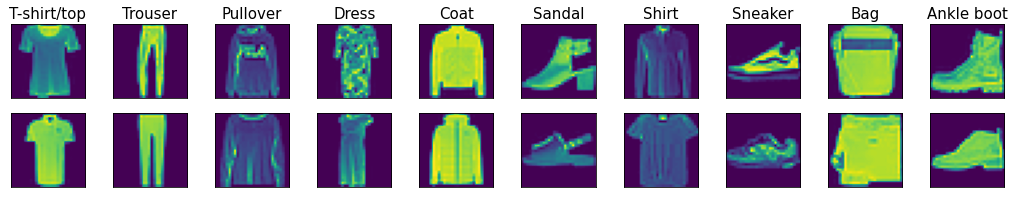

In [6]:
num_img_per_class = 2
sample_images = []
for i in range(len(classes)):
  local_data = train_val_set.data[np.array(train_val_set.targets) == i]
  rand_nums = np.random.randint(local_data.shape[0], size=num_img_per_class) + 1
  for j in rand_nums:
    sample_images.append(local_data[j])


fig, axes = plt.subplots(num_img_per_class, len(classes), figsize=(18,3))

i = 0
for col in range(len(classes)):
  axes[0][col].set_title(classes[col], fontsize=15)
  for row in range(num_img_per_class):
    axis = axes[row][col]
    axis.set_xticks([])
    axis.set_yticks([])
    axis.imshow(sample_images[i])
    i += 1

## functions

In [7]:
# Implementing affine forward & affine backward
def affine_forward(x, w, b):
    """
    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples where each example x[i] has shape (d_1, ..., d_k).

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Outputs:
    - out: output, of shape (N, M): out = X*W + b
    """

    # We must reshape each input into a vector of dimension D = d_1 * ... * d_k,
    # and then transform it to an output vector of dimension M.
    reshaped_x = x.reshape(x.shape[0], w.shape[0])
    out = (reshaped_x @ w) + b
    return out


def affine_backward(dout, x, w, b):
    """
    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - x: Input data, of shape (N, d_1, ... d_k)
    - w: Weights, of shape (D, M)
    - b: Biases, of shape (M,)

    Outputs:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    reshaped_x = x.reshape(x.shape[0], w.shape[0])
    dx = (dout @ w.T).reshape(x.shape)
    dw = reshaped_x.T @ dout
    db = np.sum(dout, axis=0)
    return dx, dw, db


# Implementing ReLU forward & ReLU backward
def relu_forward(x):
    return x * (x >= 0)


def relu_backward(dout, x):
    """
    Input:
    - dout: Upstream derivatives, of any shape
    - x: Input x, of same shape as dout

    Outputs:
    - dx: Gradient with respect to x
    """
    dx = dout * (x > 0)
    return dx


# Implementing sigmoid forward & sigmoid backward
def sigmoid_forward(x):
    return 1.0 / (1 + np.exp(-x))


def sigmoid_backward(dout, x):
    """
    Input:
    - dout: Upstream derivatives, of any shape
    - x: Input x, of same shape as dout

    Outputs:
    - dx: Gradient with respect to x
    """
    g = sigmoid_forward(x)
    return dout * g * (1 - g)


# Implementing ReLU affine forward & ReLU affine backward (an affine transform followed by a ReLU)
def relu_affine_forward(x, w, b):
    """
    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Output:
    - out: Output from the ReLU
    """
    out = affine_forward(x, w, b)
    out = relu_forward(out)
    return out


def relu_affine_backward(dout, x, w, b, out):
    """
        Inputs:
        - dout: Upstream derivatives, of any shape
        - x: Input data, of shape (N, d_1, ... d_k)
        - w: Weights, of shape (D, M)
        - b: Biases, of shape (M,)
        
        Outputs:
        - dx: Gradient with respect to x
        - dw: Gradient with respect to w
        - db: Gradient with respect to b
    """
    # out = affine_forward(x, w, b)
    dout = relu_backward(dout, out)
    dx, dw, db = affine_backward(dout, x, w, b)
    return dx, dw, db


# Implementing sigmoid affine forward & sigmoid affine backward (an affine transform followed by a sigmoid)
def sigmoid_affine_forward(x, w, b):
    """
    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Output:
    - out: Output from the ReLU
    """
    out = affine_forward(x, w, b)
    out = sigmoid_forward(out)
    return out


def sigmoid_affine_backward(dout, x, w, b, out):
    """
        Inputs:
        - dout: Upstream derivatives, of any shape
        - x: Input data, of shape (N, d_1, ... d_k)
        - w: Weights, of shape (D, M)
        - b: Biases, of shape (M,)
        
        Outputs:
        - dx: Gradient with respect to x
        - dw: Gradient with respect to w
        - db: Gradient with respect to b
    """
    # out = sigmoid_affine_forward(x, w, b)
    dout = sigmoid_backward(dout, out)
    dx, dw, db = affine_backward(dout, x, w, b)
    return dx, dw, db


# Implemneting Softmax
def softmax(x):
    """
    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    Outputs:
    - y: softmax on x
    """
    exp_x = np.exp(x)
    y = exp_x / np.sum(exp_x, axis=1).reshape(x.shape[0], 1)
    return y


# Implementing loss functions
def cross_entropy(y_hat, y):
    """
    Inputs:
    - y_hat: Matrix of predicted labels, of shape (N,C) where y[i,j] is the 
        probability of sample x[i] be in the jth class.
    Outputs:
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C
    - dy: Gradient of the loss with respect to y_hat
    """
    N = y_hat.shape[0]
    log_likelihood = -np.log(y_hat[range(N), y.astype(int)])
    loss = 1. /N * np.sum(log_likelihood)
    y_hat[range(N), y.astype(int)] -= 1
    dy = y_hat / N
    return loss, dy


def mse_error(y_hat, y):
    """
    Inputs:
    - x: Input data, of shape (N,) where x[i] is the predicted vector for 
        the ith input.
    - y: Vector of target values, of shape (N,) where y[i] is the target value
        for the ith input.

    Outputs:
    - loss: Scalar giving the loss
    - dy: Gradient of the loss with respect to y_hat
    """
    loss = 1. / y_hat.shape[0] * np.sum((y_hat - y)**2)
    dy = 2. / y_hat.shape[0] * (y_hat - y)
    return loss, dy

## Bathnormalization

In [8]:
def batchnorm_forward(x, gamma, beta, bn_params):
    mode = bn_params["mode"]
    eps = bn_params.get("eps", 1e-5)
    momentum = bn_params.get("momentum", 0.9)

    N, D = x.shape
    running_mean = bn_params.get("running_mean", np.zeros(D))
    running_var = bn_params.get("running_var", np.zeros(D))

    cache = None
    if mode == "train":
        mu = np.mean(x, axis=0)
        var = np.var(x, axis=0)

        x_hat = (x - mu) * 1.0 / np.sqrt(var + eps)
        y = gamma * x_hat + beta
        running_mean = momentum * running_mean + (1 - momentum) * mu
        running_var = momentum * running_var + (1 - momentum) * var

        cache = (x, x_hat, mu, var, eps, gamma, beta)
    else:
        x_hat = (x - running_mean) * 1.0 / np.sqrt(running_var + eps)
        y = gamma * x_hat + beta
    
    bn_params["running_mean"] = running_mean
    bn_params["running_var"] = running_var

    return y, cache


def batchnorm_backward(dout, cache):
    x, x_hat, mu, var, eps, gamma, beta = cache
    
    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout * x_hat, axis=0)

    # algoritm
    m = x.shape[0]
    istd = 1./np.sqrt(var + eps)

    dx = (gamma * istd / m) * (m * dout - np.sum(dout, axis=0)
          - istd**2 * (x - mu) * np.sum(dout * (x - mu), axis=0))

    return dx, dgamma, dbeta

## Model

In [9]:
class FNNModel:
    def __init__(
        self,
        hidden_dims,
        normalization,
        input_dim=784,
        output_dim=10,
        reg=0,
        weight_scale=0.01,
        dtype=np.float32
    ):
        self.normalization = normalization
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.params = {}
        self.bn_params = []
        self.dtype = dtype

        for i in range(self.num_layers):
          if i == 0: 
            self.params['W' + str(i + 1)] = weight_scale * np.random.randn(input_dim, hidden_dims[i])
            self.params['b' + str(i + 1)] = np.zeros(hidden_dims[i])
            if self.normalization[i]:
              self.params['gamma' + str(i + 1)] = np.ones(hidden_dims[i])
              self.params['beta' + str(i + 1)] = np.zeros(hidden_dims[i])
          elif i < self.num_layers - 1:
            self.params['W' + str(i + 1)] = weight_scale * np.random.randn(hidden_dims[i-1], hidden_dims[i])
            self.params['b' + str(i + 1)] = np.zeros(hidden_dims[i])
            if self.normalization[i]:
              self.params['gamma' + str(i + 1)] = np.ones(hidden_dims[i])
              self.params['beta' + str(i + 1)] = np.zeros(hidden_dims[i])  
          else:
            self.params['W' + str(i+1)] = weight_scale * np.random.randn(hidden_dims[i-1], output_dim)
            self.params['b' + str(i+1)] = np.zeros(output_dim)

        for k, v in self.params.items():
            self.params[k] = v.astype(self.dtype)

    def loss(self, mode, X, y=None):
        X = X.astype(self.dtype)
        self.bn_params = [{'mode': mode} for i in range(self.num_layers - 1)]
        a = {'layer0': X}
        cache = {}
        for i in range(self.num_layers):
            layer, prev_layer = 'layer'+str(i+1), 'layer'+str(i)
            W, b = self.params['W'+str(i+1)], self.params['b'+str(i+1)]
            if i < self.num_layers - 1:
                if self.normalization[i]:
                    gamma, beta = self.params['gamma'+str(i+1)], self.params['beta'+str(i+1)]
                    fc_out = affine_forward(a[prev_layer], self.params['W'+str(i+1)], self.params['b'+str(i+1)])
                    bn_out, cache[layer] = batchnorm_forward(fc_out, gamma, beta, self.bn_params[i])
                    a[layer] = relu_forward(bn_out)
                else:
                    a[layer] = relu_affine_forward(a[prev_layer], W, b)
            else:
                a[layer] = affine_forward(a[prev_layer], W, b)
        
        out = softmax(a['layer'+str(self.num_layers)])

        if mode == "test":
            return out

        grads = {}
        loss, dout = cross_entropy(out, y)

        W_i, b_i = 'W' + str(self.num_layers), 'b' + str(self.num_layers)
        dh, grads[W_i], grads[b_i] = affine_backward(dout, a['layer'+str(self.num_layers-1)], self.params[W_i], self.params[b_i])
        
        loss += 0.5 * self.reg * np.sum(self.params[W_i]**2)
        grads[W_i] += self.reg * self.params[W_i]

        for i in reversed(range(self.num_layers - 1)):
            W_i, b_i = 'W' + str(i + 1), 'b' + str(i + 1)
            gamma_i, beta_i = 'gamma' + str(i + 1), 'beta' + str(i + 1)
            layer = 'layer' + str(i + 1)

            if i < self.num_layers - 1 and self.normalization[i]:
                dh = relu_backward(dh, a['layer' + str(i + 1)])
                dh, grads[gamma_i], grads[beta_i] = batchnorm_backward(dh, cache[layer])
                dh, grads[W_i], grads[b_i] = affine_backward(dh, a['layer'+str(i)], self.params[W_i], self.params[b_i])
            else:  
                dh, grads[W_i], grads[b_i] = relu_affine_backward(dh, a['layer'+str(i)], self.params[W_i], self.params[b_i], a['layer'+str(i+1)])
            
            loss += 0.5 * self.reg * np.sum(self.params[W_i]**2)
            grads[W_i] += self.reg * self.params[W_i]
        
        return loss, grads

## Train Model

In [20]:
nn = FNNModel(
    hidden_dims=[1024, 256],
    normalization=[False, False],
    reg=0
)

In [11]:
def sgd_momentum(w, dw, learning_rate=1e-2, momentum=0.9, velocity=None):
    if velocity is None:
        velocity = np.zeros_like(w)
    v = momentum * velocity - learning_rate * dw
    next_w = w + v
    return next_w, v


def train_epoch(nnModel, dataloader):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    train_loss = 0
    train_accuracy = 0
    i = 0

    for i, (x, y) in enumerate(dataloader):
        x, y = x.numpy(), y.numpy()
        y_hat = nnModel.loss(mode='test', X=x)

        loss, grads = nnModel.loss('train', x, y)
        epoch_loss += float(loss)

        predictions = y_hat.argmax(-1)
        epoch_all += len(predictions)
        epoch_true += (predictions == y).sum()

        train_loss = epoch_loss / (i + 1)
        train_accuracy = epoch_true / epoch_all

        for k in range(nnModel.num_layers):
            W, b = nnModel.params['W' + str(k + 1)], nnModel.params['b' + str(k + 1)]
            dW, db = grads['W' + str(k + 1)], grads['b' + str(k + 1)]

            WV = nnModel.params.get('WV' + str(k + 1), np.zeros_like(W))
            bV = nnModel.params.get('bV' + str(k + 1), np.zeros_like(b))

            nnModel.params['W' + str(k + 1)], nnModel.params['WV' + str(k + 1)] = sgd_momentum(W, dW, velocity=WV)
            nnModel.params['b' + str(k + 1)], nnModel.params['bV' + str(k + 1)] = sgd_momentum(b, db, velocity=bV)

    return train_loss, train_accuracy

def evaluate_epoch(nnModel, dataloader):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    val_loss = 0
    val_accuracy = 0
    i = 0

    for i, (x, y) in enumerate(dataloader):
        x, y = x.numpy(), y.numpy()
        y_hat = nnModel.loss(mode='test', X=x)

        loss, grads = nnModel.loss('val', x, y)
        epoch_loss += float(loss)

        predictions = y_hat.argmax(-1)
        epoch_all += len(predictions)
        epoch_true += (predictions == y).sum()

        val_loss = epoch_loss / (i + 1)
        val_accuracy = epoch_true / epoch_all

    return val_loss, val_accuracy

In [12]:
from time import localtime

def getTime():
  loc_time = localtime()
  hour, min, sec = loc_time.tm_hour, loc_time.tm_min, loc_time.tm_sec
  return str(hour) + ":" + str(min) + ":" + str(sec)

In [21]:
epochs = 20

train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []

for e in range(epochs):
    train_loss, train_accuracy = train_epoch(nn, train_loader)
    eval_loss, eval_accuracy = evaluate_epoch(nn, val_loader)

    train_losses.append(train_loss)
    train_accuracies.append(float(train_accuracy))
    eval_losses.append(eval_loss)
    eval_accuracies.append(float(eval_accuracy))

    print(f'[Epoch {e+1}]\t [{getTime()}]\t', end="")
    print(f'Train Loss: {train_loss:.4f}\tTrain Accuracy: {train_accuracy:.2f}\t', end="")
    print(f'Validaion Loss: {eval_loss:.4f}\t\tValidation Accuracy: {eval_accuracy:.2f}')

[Epoch 1]	 [23:14:4]	Train Loss: 1.6072	Train Accuracy: 0.41	Validaion Loss: 0.8346		Validation Accuracy: 0.69
[Epoch 2]	 [23:14:28]	Train Loss: 0.7095	Train Accuracy: 0.74	Validaion Loss: 0.6418		Validation Accuracy: 0.76
[Epoch 3]	 [23:14:51]	Train Loss: 0.5795	Train Accuracy: 0.80	Validaion Loss: 0.5555		Validation Accuracy: 0.81
[Epoch 4]	 [23:15:13]	Train Loss: 0.5132	Train Accuracy: 0.82	Validaion Loss: 0.5029		Validation Accuracy: 0.82
[Epoch 5]	 [23:15:38]	Train Loss: 0.4752	Train Accuracy: 0.83	Validaion Loss: 0.4695		Validation Accuracy: 0.83
[Epoch 6]	 [23:16:2]	Train Loss: 0.4431	Train Accuracy: 0.85	Validaion Loss: 0.4498		Validation Accuracy: 0.84
[Epoch 7]	 [23:16:28]	Train Loss: 0.4221	Train Accuracy: 0.85	Validaion Loss: 0.4303		Validation Accuracy: 0.84
[Epoch 8]	 [23:16:51]	Train Loss: 0.4054	Train Accuracy: 0.86	Validaion Loss: 0.4199		Validation Accuracy: 0.85
[Epoch 9]	 [23:17:16]	Train Loss: 0.3922	Train Accuracy: 0.86	Validaion Loss: 0.4113		Validation Accuracy:

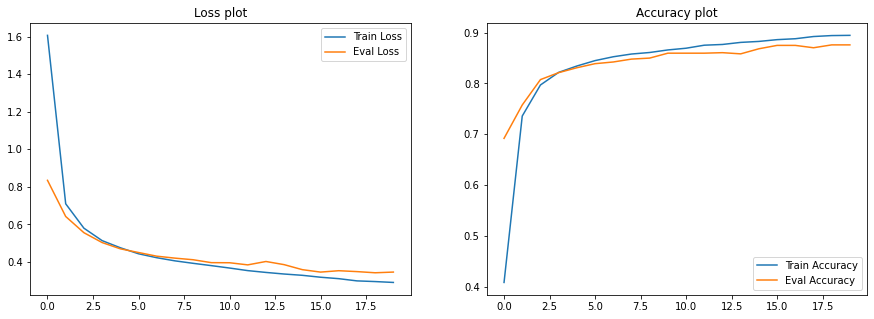

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axis = axes[0]
axis.plot(train_losses)
axis.plot(eval_losses)
axis.set_title('Loss plot')
axis.legend(['Train Loss', 'Eval Loss'])

axis = axes[1]
axis.plot(train_accuracies)
axis.plot(eval_accuracies)
axis.set_title('Accuracy plot')
axis.legend(['Train Accuracy', 'Eval Accuracy'])

In [23]:
test_loss, test_accuracy = evaluate_epoch(nn, test_loader)

print(test_accuracy)

0.8722


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
[0 0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9 9]


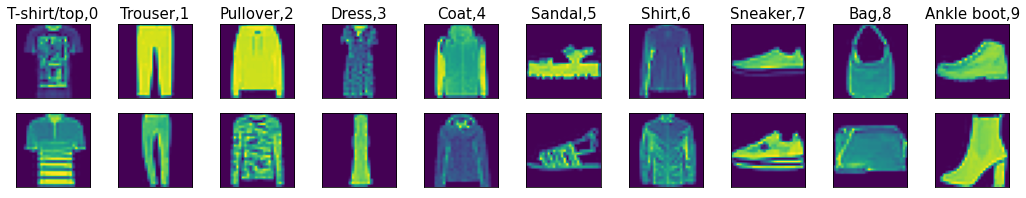

In [74]:
def donirm(x):
    y = np.zeros_like(x)
    mu = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    std[std == 0] = 1
    y = (x - mu) / std
    return y

num_img_per_class = 2
sample_images = np.array([])
for i in range(len(classes)):
    local_data = train_val_set.data[np.array(train_val_set.targets) == i]
    rand_nums = np.random.randint(local_data.shape[0], size=num_img_per_class) + 1
    for j in rand_nums:
        if sample_images.shape[0] == 0:
            sample_images = local_data[j].numpy().T
        else:
            sample_images = np.dstack((sample_images, local_data[j].numpy().T))

sample_images = sample_images.T

fig, axes = plt.subplots(num_img_per_class, len(classes), figsize=(18,3))

y_hat = nn.loss('test', donirm(sample_images))
pred = np.argmax(y_hat, axis=1)

print(classes)
print(pred)

i = 0
for col in range(len(classes)):
    tit = classes[col] + ',' + str(pred[2*col])
    axes[0][col].set_title(tit, fontsize=15)
    for row in range(num_img_per_class):
        axis = axes[row][col]
        axis.set_xticks([])
        axis.set_yticks([])
        axis.imshow(sample_images[i])
        i += 1
